## Import the required packages

In [127]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#Pandas Profiling
import pandas_profiling
import pandas_summary


#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

from imblearn.over_sampling import RandomOverSampler

#FeatureEngineering
#!pip install lightgbm
#from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import  textblob
#import xgboost
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import Word

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

print(pd.__version__)
print(np.__version__)
print(sns.__version__)

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

0.25.3
1.16.5
0.9.0
TensorFlow Version: 2.1.0
Default GPU Device: /device:GPU:0


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shaur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shaur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shaur\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Important User Defined Functions

In [128]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([
        x.count(),
        x.isnull().sum(),
        x.sum(),
        x.mean(),
        x.median(),
        x.std(),
        x.var(),
        x.min(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.10),
        x.quantile(0.25),
        x.quantile(0.50),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99),
        x.max()
    ],
                     index=[
                         'N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD', 'VAR',
                         'MIN', 'P1', 'P5', 'P10', 'P25', 'P50', 'P75', 'P90',
                         'P95', 'P99', 'MAX'
                     ])

In [129]:
#Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([
        x.count(),
        x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
        round(Mode.iloc[0, 1] * 100 / x.count(), 2)
    ],
                     index=['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [130]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats='mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [131]:
#An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop(colname, axis=1, inplace=True)
    return df

In [132]:
# create user defined function to create the freq plots
def fn_countplot(pd_series):
    plt.figure(figsize=(5, 3))
    sns.countplot(y=pd_series)
    print('This is a freq chart for ' + pd_series.name)
    plt.show()
    return

In [133]:
#Outlier Treatment using the 99 percentile method.
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

### Reading the data into a DataFrame

In [134]:
data = pd.read_csv('C:/Users/shaur/Downloads/6. Analyzing online Job Postings/data job posts.csv')

In [135]:
data.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             19001 non-null object
date                19001 non-null object
Title               18973 non-null object
Company             18994 non-null object
AnnouncementCode    1208 non-null object
Term                7676 non-null object
Eligibility         4930 non-null object
Audience            640 non-null object
StartDate           9675 non-null object
Duration            10798 non-null object
Location            18969 non-null object
JobDescription      15109 non-null object
JobRequirment       16479 non-null object
RequiredQual        18517 non-null object
Salary              9622 non-null object
ApplicationP        18941 non-null object
OpeningDate         18295 non-null object
Deadline            18936 non-null object
Notes               2211 non-null object
AboutC              12470 non-null object
Attach              1559 non-null object
Year              

In [137]:
#Pandas Profiling of the data

report = pandas_profiling.ProfileReport(data)

report.to_file(
    'C:/Users/shaur/Downloads/6. Analyzing online Job Postings/PandasProfilingreport.html'
)

report

In [138]:
data.rename(columns={
    'ApplicationP': 'ApplicationProcedure',       #Renaiming the unclear columns for better understanding of the column names.
    'AboutC': 'AboutCompany',
    'RequiredQual': 'RequiredQualifications',
    'JobRequirment': 'JobRequirement'
},
            inplace=True)

In [139]:
data.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationProcedure,OpeningDate,Deadline,Notes,AboutCompany,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [140]:
# Display the entry counts for the Year column
data['Year'].value_counts()

2012    2149
2015    2009
2013    2009
2014    1983
2008    1785
2011    1697
2007    1538
2010    1511
2009    1191
2005    1138
2006    1116
2004     875
Name: Year, dtype: int64

In [141]:
data.StartDate.value_counts()

ASAP                             4754
Immediately                       773
As soon as possible               543
Upon hiring                       261
Immediate                         259
                                 ... 
10 August 2009                      1
Urgent                              1
19 March 2010, 19:00                1
When-actually-employed basis.       1
10 March 2011                       1
Name: StartDate, Length: 1186, dtype: int64

In [142]:
# Checking initial values of start date
data.StartDate.value_counts()[-20:]

15 August 2014                             1
14 September 2009                          1
01 November 2012, 4 p.m.                   1
in the nearest future                      1
Upon availability                          1
15 March 2009                              1
25 January 2013                            1
September 6                                1
27 April 2013                              1
31 August 2006                             1
By the end of the summer 2005              1
25 March 2009                              1
13 November 2015                           1
03 October 2006, from 14:15 till 16:15.    1
31 Aug & 01 Sep  or  02 & 03 Sep 2004      1
10 August 2009                             1
Urgent                                     1
19 March 2010, 19:00                       1
When-actually-employed basis.              1
10 March 2011                              1
Name: StartDate, dtype: int64

## Data Columns Selection

In [143]:
data.columns

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirement', 'RequiredQualifications', 'Salary',
       'ApplicationProcedure', 'OpeningDate', 'Deadline', 'Notes',
       'AboutCompany', 'Attach', 'Year', 'Month', 'IT'],
      dtype='object')

In [144]:
data.describe()

,Year,Month
count,19001.000000,19001.000000
mean,2010.274722,6.493869
std,3.315609,3.405503
min,2004.000000,1.000000
25%,2008.000000,3.000000
50%,2011.000000,7.000000
75%,2013.000000,9.000000
max,2015.000000,12.000000


In [145]:
#We will choose the important features here. All the discarded variables are either irrelevant or have high missing values.

#Removed Variables : ['date','AnnouncementCode', 'Term', 'Eligibility',
#'Audience', 'StartDate', 'Duration', 'Location', 'Salary'
#'OpeningDate', 'Deadline', 'Notes','Attach']

data = data[[
    'jobpost', 'Title', 'Company', 'JobDescription', 'JobRequirement',
    'RequiredQualifications', 'ApplicationProcedure', 'AboutCompany', 'Year',
    'Month', 'IT'
]]

In [146]:
data.head()

,jobpost,Title,Company,JobDescription,JobRequirement,RequiredQualifications,ApplicationProcedure,AboutCompany,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,AMERIA Investment Consulting Company,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\nindividu...","To apply for this position, please submit a\nc...",NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,- Bachelor's Degree; Master's is preferred;\n-...,Please submit a cover letter and resume to:\nI...,The International Research & Exchanges Board (...,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,Country Coordinator,Caucasus Environmental NGO Network (CENN),Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Please send resume or CV toursula.kazarian@......,The Caucasus Environmental NGO Network is a\nn...,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,BCC Specialist,Manoff Group,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",Please send cover letter and resume to Amy\nPe...,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,Software Developer,Yerevan Brandy Company,NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...,Successful candidates should submit\n- CV; \n-...,NaN,2004,1,True


In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 11 columns):
jobpost                   19001 non-null object
Title                     18973 non-null object
Company                   18994 non-null object
JobDescription            15109 non-null object
JobRequirement            16479 non-null object
RequiredQualifications    18517 non-null object
ApplicationProcedure      18941 non-null object
AboutCompany              12470 non-null object
Year                      19001 non-null int64
Month                     19001 non-null int64
IT                        19001 non-null bool
dtypes: bool(1), int64(2), object(8)
memory usage: 1.5+ MB


In [148]:
data.isna().sum()

jobpost                      0
Title                       28
Company                      7
JobDescription            3892
JobRequirement            2522
RequiredQualifications     484
ApplicationProcedure        60
AboutCompany              6531
Year                         0
Month                        0
IT                           0
dtype: int64

In [149]:
#The y variable is boolean. Converting it to int to classify it to 0 and 1.

data['IT'] = data['IT'].astype(int)

In [150]:
#Summarisation of data.
data.apply(categorical_var_summary)

,jobpost,Title,Company,JobDescription,JobRequirement,RequiredQualifications,ApplicationProcedure,AboutCompany,Year,Month,IT
N,19001,18973,18994,15109,16479,18517,18941,12470,19001.00,19001.00,19001.00
NMISS,0,28,7,3892,2522,484,60,6531,0.00,0.00,0.00
MODE,Career Center NGO\nTITLE: English Language Co...,Accountant,ArmenTel CJSC,The incumbent will work under the direct super...,- Participate in application design;\n- Provid...,- Excellent communication skills;\n- Good oral...,"To apply for this position, please open\nwww.c...",Mentor Graphics Development Services CJSC is a...,2012.00,3.00,0.00
FREQ,11,328,353,55,51,43,68,196,2149.00,1702.00,15242.00
PERCENT,0.06,1.73,1.86,0.36,0.31,0.23,0.36,1.57,11.31,8.96,80.22


In [151]:
#Missing value imputation
# Treating missing values

data[[
    'jobpost', 'Title', 'Company', 'JobDescription', 'JobRequirement',
    'RequiredQualifications', 'ApplicationProcedure', 'AboutCompany', 'Year',
    'Month', 'IT'
]] = data[[
    'jobpost', 'Title', 'Company', 'JobDescription', 'JobRequirement',
    'RequiredQualifications', 'ApplicationProcedure', 'AboutCompany', 'Year',
    'Month', 'IT'
]].fillna(data[[
    'jobpost', 'Title', 'Company', 'JobDescription', 'JobRequirement',
    'RequiredQualifications', 'ApplicationProcedure', 'AboutCompany', 'Year',
    'Month', 'IT'
]].mode().ix[0])

In [152]:
data.apply(categorical_var_summary)

,jobpost,Title,Company,JobDescription,JobRequirement,RequiredQualifications,ApplicationProcedure,AboutCompany,Year,Month,IT
N,19001,19001,19001,19001,19001,19001,19001,19001,19001.00,19001.00,19001.00
NMISS,0,0,0,0,0,0,0,0,0.00,0.00,0.00
MODE,Career Center NGO\nTITLE: English Language Co...,Accountant,ArmenTel CJSC,The incumbent will work under the direct super...,- Participate in application design;\n- Provid...,- Excellent communication skills;\n- Good oral...,"To apply for this position, please open\nwww.c...",Mentor Graphics Development Services CJSC is a...,2012.00,3.00,0.00
FREQ,11,356,360,3947,2573,527,128,6727,2149.00,1702.00,15242.00
PERCENT,0.06,1.87,1.89,20.77,13.54,2.77,0.67,35.4,11.31,8.96,80.22


In [153]:
data['Title'].value_counts()[:50]

Accountant                                356
Chief Accountant                          219
Medical Representative                    216
Sales Manager                             166
Administrative Assistant                  155
Lawyer                                    151
Software Developer                        134
Project Manager                           117
English Language Courses                  109
Web Developer                             101
Java Developer                             88
Marketing Specialist                       87
Office Manager                             85
Receptionist/ Administrative Assistant     77
Graphic Designer                           75
System Administrator                       75
Marketing Manager                          72
Senior Java Developer                      69
Software Engineer                          69
QA Engineer                                66
PHP Developer                              65
Senior Software Engineer          

In [154]:
data.head()

,jobpost,Title,Company,JobDescription,JobRequirement,RequiredQualifications,ApplicationProcedure,AboutCompany,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,AMERIA Investment Consulting Company,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\nindividu...","To apply for this position, please submit a\nc...",Mentor Graphics Development Services CJSC is a...,2004,1,0
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),The incumbent will work under the direct super...,- Participate in application design;\n- Provid...,- Bachelor's Degree; Master's is preferred;\n-...,Please submit a cover letter and resume to:\nI...,The International Research & Exchanges Board (...,2004,1,0
2,Caucasus Environmental NGO Network (CENN)\nJOB...,Country Coordinator,Caucasus Environmental NGO Network (CENN),Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Please send resume or CV toursula.kazarian@......,The Caucasus Environmental NGO Network is a\nn...,2004,1,0
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,BCC Specialist,Manoff Group,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",Please send cover letter and resume to Amy\nPe...,Mentor Graphics Development Services CJSC is a...,2004,1,0
4,Yerevan Brandy Company\nJOB TITLE: Software D...,Software Developer,Yerevan Brandy Company,The incumbent will work under the direct super...,- Rendering technical assistance to Database M...,- University degree; economical background is ...,Successful candidates should submit\n- CV; \n-...,Mentor Graphics Development Services CJSC is a...,2004,1,1


### Job postings per year

In [155]:
y = pd.DataFrame(data.Year.value_counts().reset_index())
y['Job Postings'] = y.Year
y['Year'] = y['index']
y.drop('index', axis=1, inplace=True)
y.sort_values(by='Year', inplace=True)
y

,Year,Job Postings
11,2004,875
9,2005,1138
10,2006,1116
6,2007,1538
4,2008,1785
8,2009,1191
7,2010,1511
5,2011,1697
0,2012,2149
2,2013,2009


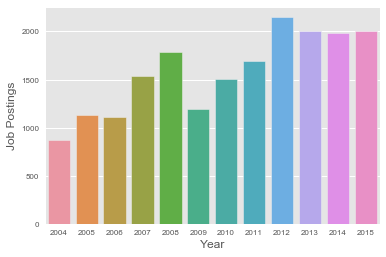

<Figure size 1440x720 with 0 Axes>

In [160]:
sns.barplot(x='Year', y='Job Postings', data=y)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.show()

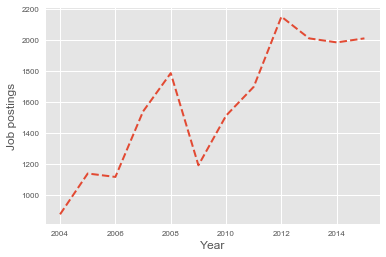

<Figure size 1440x720 with 0 Axes>

In [161]:
plt.plot('Year', 'Job Postings', data=y)
plt.style.use(['ggplot'])
plt.xlabel('Year')
plt.ylabel('Job postings')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
plt.figure(figsize=(20, 10))
plt.show()

## Top job posts every Year(2004-2015) 

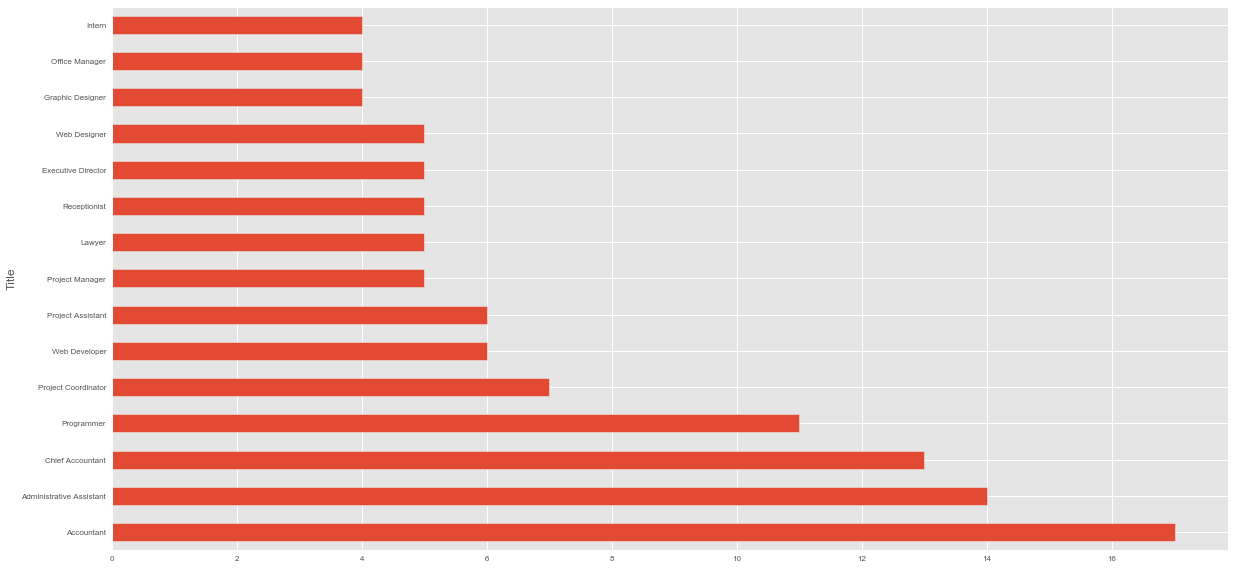

In [164]:
#2004

yr_2004 = data[data.Year == 2004].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use(['ggplot'])
plt.figure(figsize=(20, 10))
yr_2004.jobpost.plot('barh')
plt.show()

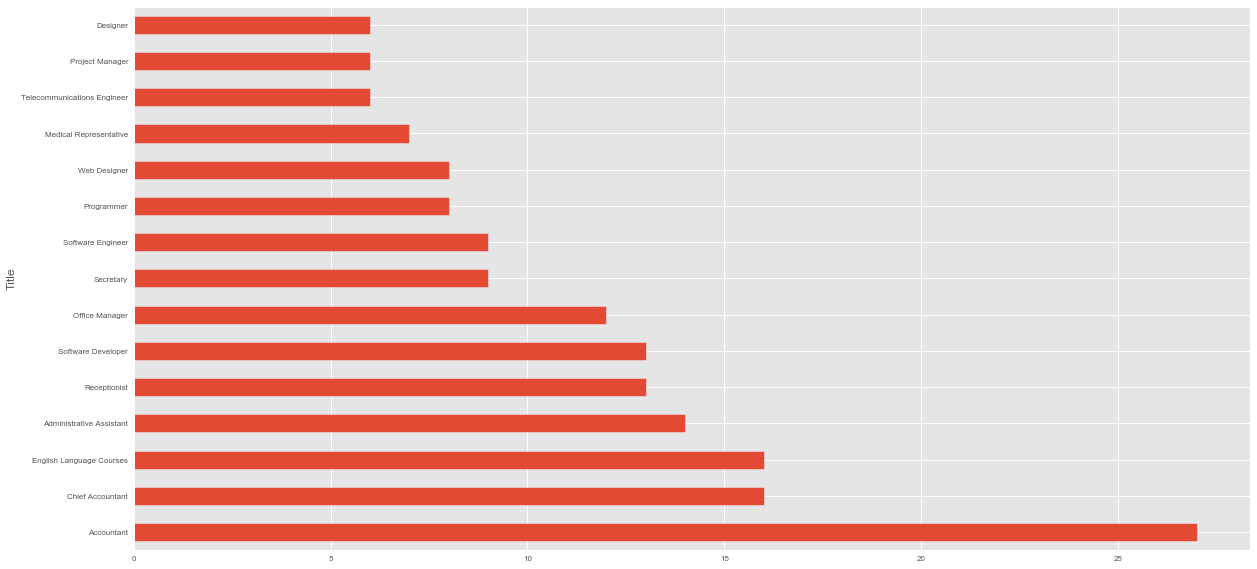

In [165]:
#2005

yr_2005 = data[data.Year == 2005].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2005.jobpost.plot('barh')
plt.show()

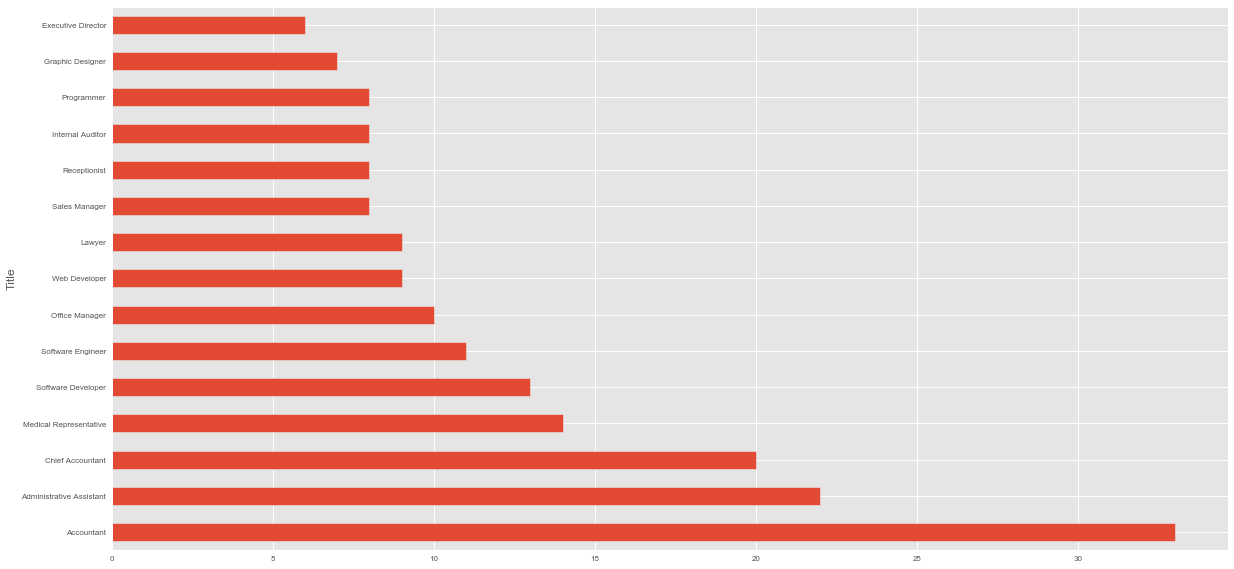

In [166]:
#2006

yr_2006 = data[data.Year == 2006].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2006.jobpost.plot('barh')
plt.show()

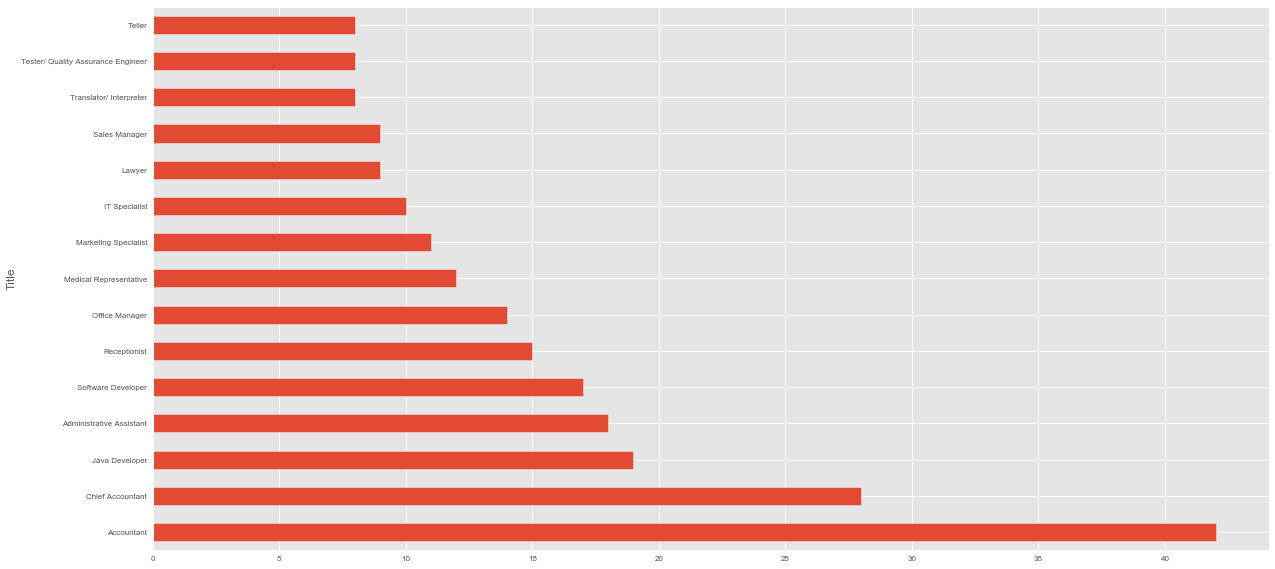

In [167]:
#2007

yr_2007 = data[data.Year == 2007].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2007.jobpost.plot('barh')
plt.show()

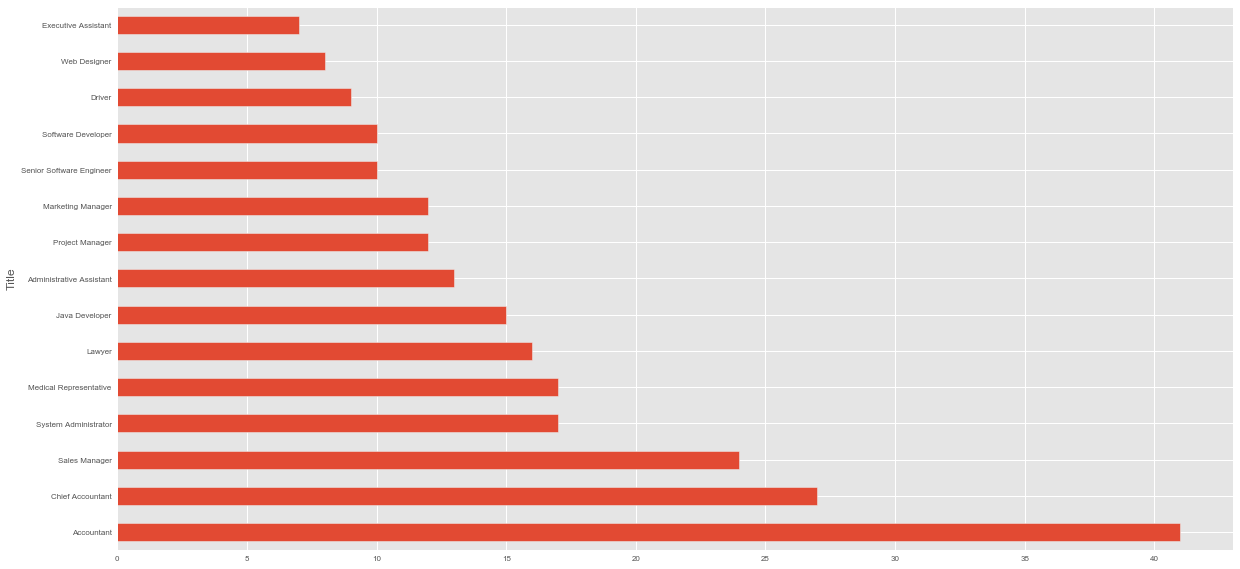

In [168]:
#2008

yr_2008 = data[data.Year == 2008].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2008.jobpost.plot('barh')
plt.show()

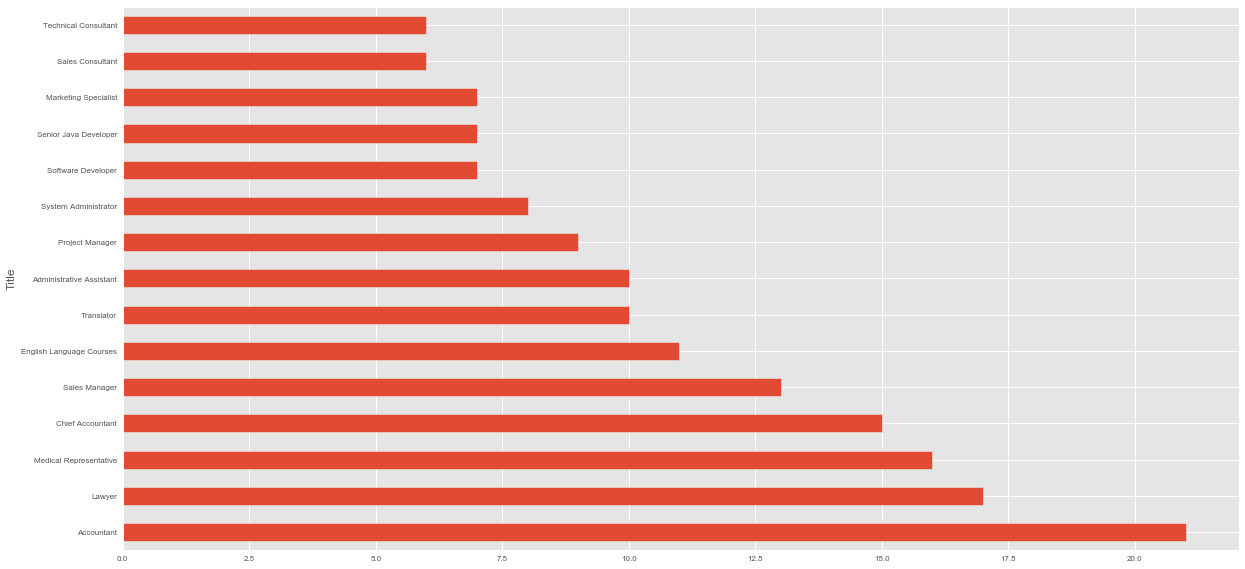

In [169]:
#2009

yr_2009 = data[data.Year == 2009].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2009.jobpost.plot('barh')
plt.show()

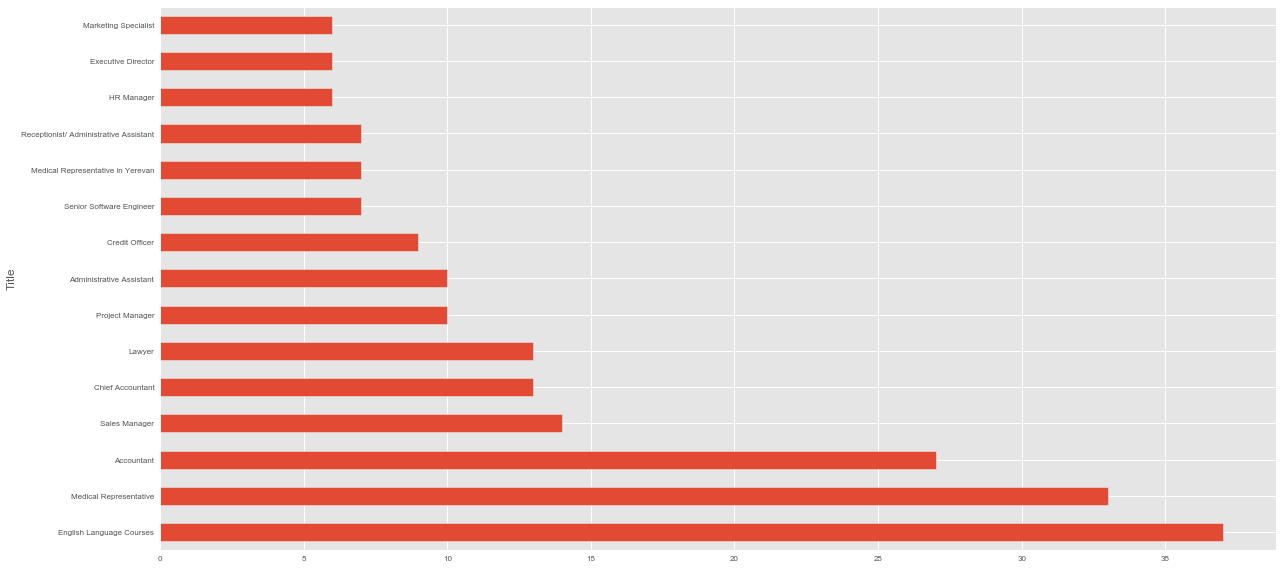

In [170]:
#2010

yr_2010 = data[data.Year == 2010].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2010.jobpost.plot('barh')
plt.show()

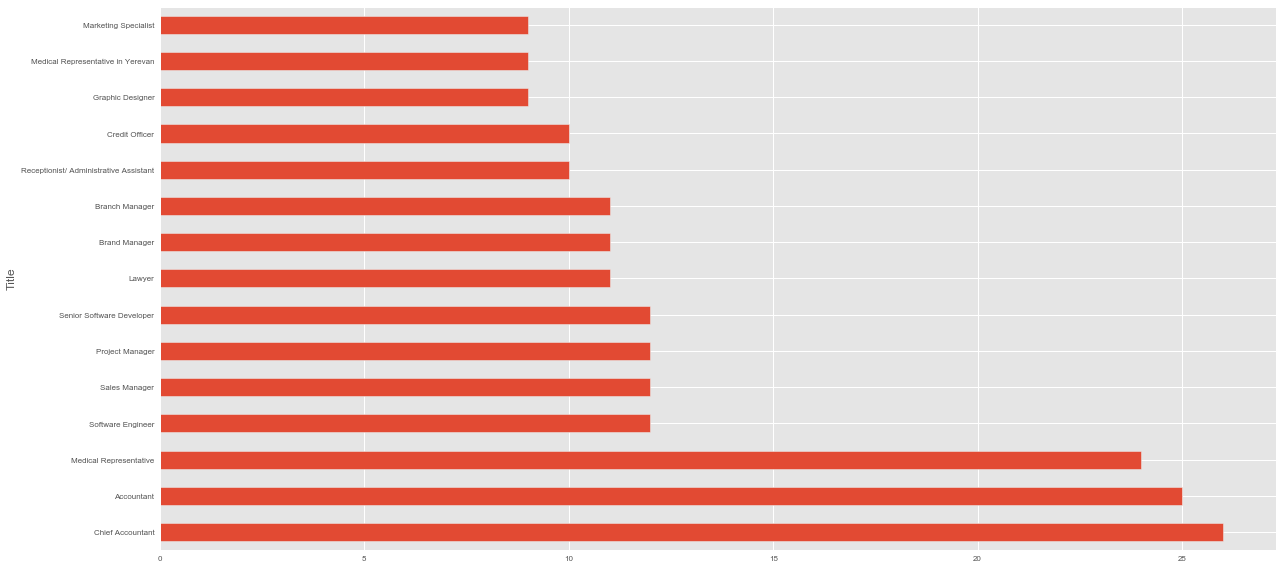

In [171]:
#2011

yr_2011 = data[data.Year == 2011].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2011.jobpost.plot('barh')
plt.show()

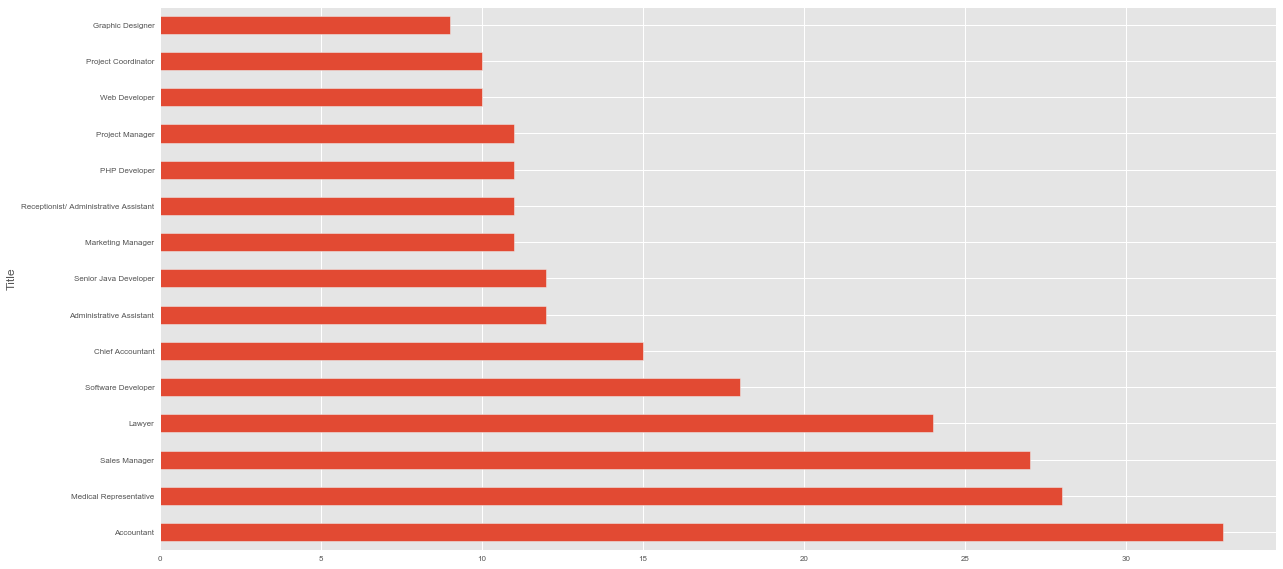

In [172]:
#2012

yr_2012 = data[data.Year == 2012].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2012.jobpost.plot('barh')
plt.show()

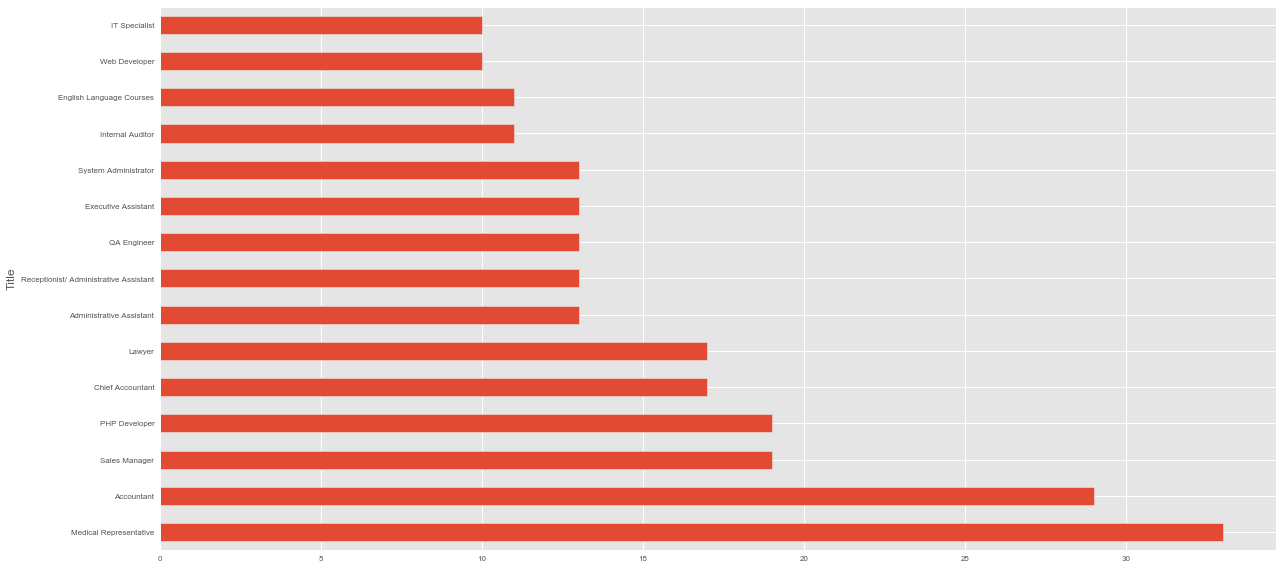

In [173]:
#2013

yr_2013 = data[data.Year == 2013].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2013.jobpost.plot('barh')
plt.show()

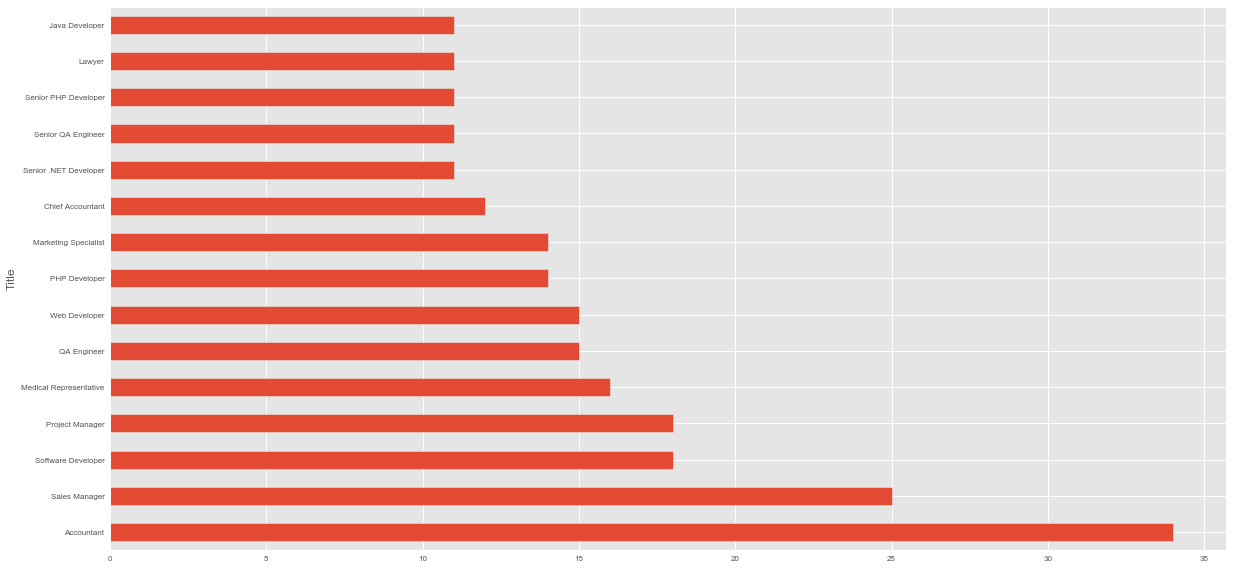

In [174]:
#2014

yr_2014 = data[data.Year == 2014].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2014.jobpost.plot('barh')
plt.show()

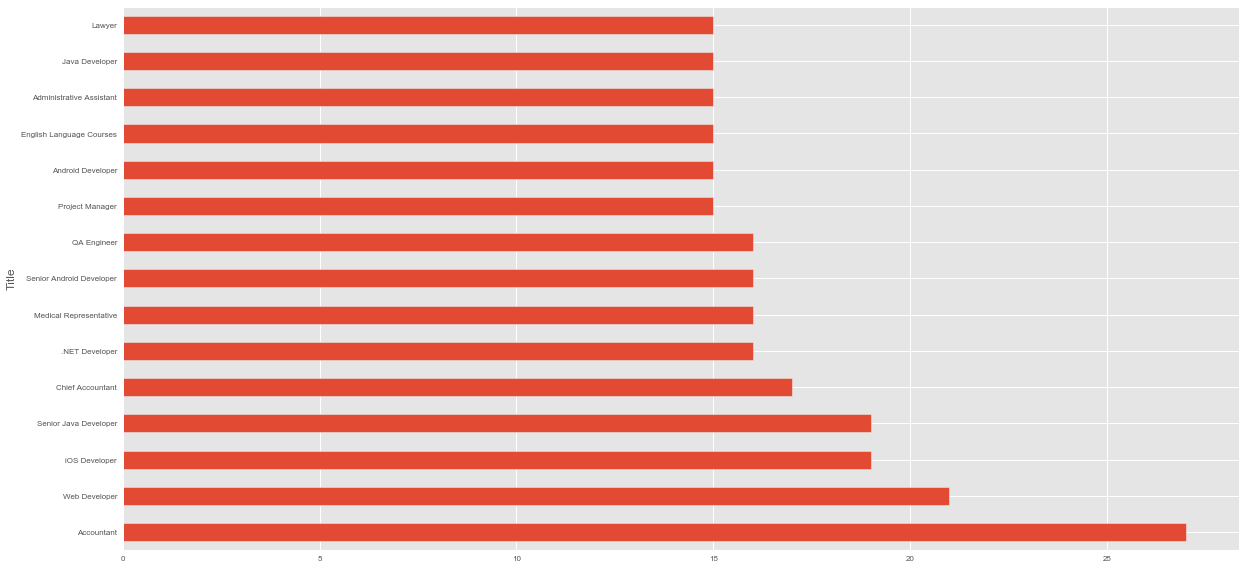

In [175]:
#2015

yr_2015 = data[data.Year == 2015].groupby('Title').count().sort_values(
    by='jobpost', ascending=False).head(15)
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
yr_2015.jobpost.plot('barh')
plt.show()

## Supervised Learning

### Basic Exploratory Analysis

In [176]:
df = data[['RequiredQualifications', 'IT']]

In [177]:
df.head()

,RequiredQualifications,IT
0,"To perform this job successfully, an\nindividu...",0
1,- Bachelor's Degree; Master's is preferred;\n-...,0
2,"- Degree in environmentally related field, or ...",0
3,"- Advanced degree in public health, social sci...",0
4,- University degree; economical background is ...,1


In [178]:
df['RequiredQualifications'] = df['RequiredQualifications'].astype(str)
df['count_sent'] = df["RequiredQualifications"].apply(
    lambda x: len(re.findall("\n", str(x))) + 1)

#Word count in each comment:
df['count_word'] = df["RequiredQualifications"].apply(
    lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word'] = df["RequiredQualifications"].apply(
    lambda x: len(set(str(x).split())))

#Letter count
df['count_letters'] = df["RequiredQualifications"].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word'] + 1)

#punctuation count
df["count_punctuations"] = df["RequiredQualifications"].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["RequiredQualifications"].apply(
    lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df["RequiredQualifications"].apply(
    lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df["RequiredQualifications"].apply(
    lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df["RequiredQualifications"].apply(
    lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
df["mean_word_len"] = df["RequiredQualifications"].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['RequiredQualifications'].apply(
    lambda x: len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['RequiredQualifications'].apply(
    lambda x: len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['RequiredQualifications'].apply(
    lambda x: len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['RequiredQualifications'].apply(
    lambda x: len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['RequiredQualifications'].apply(
    lambda x: len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['RequiredQualifications'].apply(
    lambda x: len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['RequiredQualifications'].apply(
    lambda x: dict([[t, x.split().count(t)] for t in set(x.split())]))

pos_family = {
    'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
    'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
    'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    'adj': ['JJ', 'JJR', 'JJS'],
    'adv': ['RB', 'RBR', 'RBS', 'WRB']
}


# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = RequiredQualificationsblob.RequiredQualificationsBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt


df['noun_count'] = df['RequiredQualifications'].apply(
    lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['RequiredQualifications'].apply(
    lambda x: check_pos_tag(x, 'verb'))
df['adj_count'] = df['RequiredQualifications'].apply(
    lambda x: check_pos_tag(x, 'adj'))
df['adv_count'] = df['RequiredQualifications'].apply(
    lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['RequiredQualifications'].apply(
    lambda x: check_pos_tag(x, 'pron'))

In [179]:
df.head()

,RequiredQualifications,IT,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,count_words_upper,count_words_lower,...,alphabetetics,Spaces,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count
0,"To perform this job successfully, an\nindividu...",0,53,387,228,2832,7.298969,101,7,315,...,287,0,0,0,"{'State': 1, 'CFA,': 1, 'reporting': 1, 'manag...",0,0,0,0,0
1,- Bachelor's Degree; Master's is preferred;\n-...,0,7,51,36,352,6.769231,15,1,31,...,36,0,0,0,"{'part': 1, 'Bachelor's': 1, 'public': 1, 'REM...",0,0,0,0,0
2,"- Degree in environmentally related field, or ...",0,6,40,35,279,6.804878,11,1,27,...,28,0,0,0,"{'Armenian,': 1, 'environmentally': 1, 'REMUNE...",0,0,0,0,0
3,"- Advanced degree in public health, social sci...",0,13,95,69,705,7.343750,29,1,72,...,66,0,1,0,"{'Knowledge': 1, 'public': 1, 'processing': 1,...",0,0,0,0,0
4,- University degree; economical background is ...,1,7,53,43,340,6.296296,15,5,27,...,35,0,0,1,"{'SQL': 1, 'REMUNERATION:': 1, 'economical': 1...",0,0,0,0,0


### Calculating Sentiment analysis using Textblob module

In [180]:
df['sentiment'] = df["RequiredQualifications"].apply(
    lambda x: TextBlob(x).sentiment.polarity)

In [181]:
df[['RequiredQualifications', 'IT', 'sentiment']]

,RequiredQualifications,IT,sentiment
0,"To perform this job successfully, an\nindividu...",0,0.155901
1,- Bachelor's Degree; Master's is preferred;\n-...,0,0.181250
2,"- Degree in environmentally related field, or ...",0,0.080000
3,"- Advanced degree in public health, social sci...",0,0.143704
4,- University degree; economical background is ...,1,0.242857
...,...,...,...
18996,- At least 5 years of experience in Interface/...,0,0.250000
18997,"- University degree, ideally business related;...",0,0.252632
18998,"- Degree in Business, Marketing or a related f...",0,0.133333
18999,- At least 1 year of experience in online sale...,0,0.255284


In [182]:
df['IT'].value_counts()

0    15242
1     3759
Name: IT, dtype: int64

In [183]:
# define X and y
X = df.RequiredQualifications
y = df.IT

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14250,)
(4751,)
(14250,)
(4751,)


In [184]:
df.shape

(19001, 26)

In [185]:
df.head()

,RequiredQualifications,IT,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,count_words_upper,count_words_lower,...,Spaces,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment
0,"To perform this job successfully, an\nindividu...",0,53,387,228,2832,7.298969,101,7,315,...,0,0,0,"{'State': 1, 'CFA,': 1, 'reporting': 1, 'manag...",0,0,0,0,0,0.155901
1,- Bachelor's Degree; Master's is preferred;\n-...,0,7,51,36,352,6.769231,15,1,31,...,0,0,0,"{'part': 1, 'Bachelor's': 1, 'public': 1, 'REM...",0,0,0,0,0,0.181250
2,"- Degree in environmentally related field, or ...",0,6,40,35,279,6.804878,11,1,27,...,0,0,0,"{'Armenian,': 1, 'environmentally': 1, 'REMUNE...",0,0,0,0,0,0.080000
3,"- Advanced degree in public health, social sci...",0,13,95,69,705,7.343750,29,1,72,...,0,1,0,"{'Knowledge': 1, 'public': 1, 'processing': 1,...",0,0,0,0,0,0.143704
4,- University degree; economical background is ...,1,7,53,43,340,6.296296,15,5,27,...,0,0,1,"{'SQL': 1, 'REMUNERATION:': 1, 'economical': 1...",0,0,0,0,0,0.242857


### Creating user defined functions for clean the text and pre-process the data

In [186]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()  #Text into lower case.
    text = text.strip(
    )  #Remove spaces at the beginning and at the end of the string aka. Removing whitespaces.
    text = re.sub(r' +', ' ', text)  #Replace substrings
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return (text)

In [187]:
#Removing stop words with NLTK in Python

stop = set(nltk.corpus.stopwords.words('english'))

nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [188]:
import string


def pre_process(text):
    #text = text.str.replace('/','')                           #Replacing the / with none
    #text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    #text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,']", "", text)      #Replacing special character with none
    #text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    #text = text.apply(lambda x: " ".join(x.translate(str.maketrans('', '', string.punctuation)) for x in x.split() if x.isalpha()))
    text = text.apply(
        lambda x: " ".join(x for x in x.split()
                           if x not in stop))  #Removing stop words
    #text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
    #text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
    #text = text.apply(lambda x: " ".join(stemmer_func(word) for word in x.split()))        #Stemming
    #text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))   #lemmatization
    #text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return (text)

In [189]:
X_train.head()

9332    - Higher education (preferably in Economics);\...
4060    - Relevant experience in insurance field is a ...
4107    - University degree in agricultural marketing,...
8791    - At least Bachelors degree in Marketing or a ...
9959    - Bachelors or higher degree in Computer Scien...
Name: RequiredQualifications, dtype: object

In [190]:
X_test.head()

1251     - Strong character, sharp and goal oriented pe...
6673     The successful applicant will ideally possess\...
17372    - Master's degree in Computer Science, Managem...
3442     - An English speaking local counterpart with e...
9689     - At least 4 years of professional experience ...
Name: RequiredQualifications, dtype: object

In [191]:
#Abbrevations and Words correction

X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [192]:
X_train.head()

9332     higher education preferably in economics\n at...
4060     relevant experience in insurance field is a p...
4107     university degree in agricultural marketing e...
8791     at least bachelors degree in marketing or a r...
9959     bachelors or higher degree in computer scienc...
Name: RequiredQualifications, dtype: object

In [193]:
#Pre processing and cleaning the data.

X_train = pre_process(X_train)
X_test = pre_process(X_test)

In [194]:
X_train.head()

9332    higher education preferably economics least ye...
4060    relevant experience insurance field plus highe...
4107    university degree agricultural marketing econo...
8791    least bachelors degree marketing related field...
9959    bachelors higher degree computer sciences rela...
Name: RequiredQualifications, dtype: object

In [195]:
X_test.head()

1251     strong character sharp goal oriented personali...
6673     successful applicant ideally possess following...
17372    masters degree computer science management rel...
3442     english speaking local counterpart experience ...
9689     least years professional experience project ma...
Name: RequiredQualifications, dtype: object

### Vectorization (Count, Tfidf, Hashing)
        - Charter level
        - Word level
        - n-grams

In [197]:
#Train
count_vect = CountVectorizer(
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    min_df=5,
    encoding='latin-1',
)
xtrain_count = count_vect.fit_transform(X_train)

In [198]:
xtrain_count

<14250x4715 sparse matrix of type '<class 'numpy.int64'>'
	with 596821 stored elements in Compressed Sparse Row format>

### View the document term metrics

In [199]:
dtm=xtrain_count.toarray()

In [200]:
dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [201]:
count_vect.get_feature_names()

['a',
 'aas',
 'abilities',
 'ability',
 'able',
 'abovementioned',
 'abroad',
 'absolute',
 'absorb',
 'abstract',
 'abuse',
 'ac',
 'academic',
 'acca',
 'accacpa',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'access',
 'accessibility',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accomplishments',
 'accordance',
 'according',
 'accordingly',
 'account',
 'accountability',
 'accountable',
 'accountancy',
 'accountant',
 'accountants',
 'accounting',
 'accountingfinance',
 'accountingoriented',
 'accounts',
 'accreditation',
 'accredited',
 'accuracy',
 'accurate',
 'accurately',
 'accurateness',
 'achieve',
 'achieved',
 'achievement',
 'achievements',
 'achieving',
 'aci',
 'acquaintance',
 'acquire',
 'acquired',
 'acquis',
 'acquisition',
 'acrobat',
 'across',
 'act',
 'acting',
 'action',
 'actionable',
 'actionoriented',
 'actions',
 'actionscript',
 'active',
 'actively',
 'activemq',
 'activeness',
 'activities',
 'activity',
 'actors',
 'acts

In [202]:
dtm1 = pd.DataFrame(dtm, columns=count_vect.get_feature_names())

In [203]:
dtm1.head()

,a,aas,abilities,ability,able,abovementioned,abroad,absolute,absorb,abstract,...,yii,young,youth,youtube,ysu,yui,zend,zendframework,zigbee,zones
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Vectorization (count, tfidf) for both train & test

In [204]:
#Train
count_vect = CountVectorizer(
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    min_df=5,
    encoding='latin-1',
)

xtrain_count = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(xtrain_count)

#Test
#count_vect = CountVectorizer()
xtest_count = count_vect.transform(X_test)

#tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.transform(xtest_count)

In [205]:
X_train_tfidf

<14250x4715 sparse matrix of type '<class 'numpy.float64'>'
	with 596821 stored elements in Compressed Sparse Row format>

In [206]:
dtm2 = pd.DataFrame(X_train_tfidf.toarray(),
                    columns=count_vect.get_feature_names())

In [207]:
dtm2.head(20)

,a,aas,abilities,ability,able,abovementioned,abroad,absolute,absorb,abstract,...,yii,young,youth,youtube,ysu,yui,zend,zendframework,zigbee,zones
0,0.0,0.0,0.000000,0.083628,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.173852,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.169590,0.119321,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.043787,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.087768,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.000000,0.091242,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.000000,0.041214,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(
    analyzer='word',
    token_pattern='\w{1,}',
    ngram_range=(1, 2),
)
tfidf_vect_ngram.fit(df['RequiredQualifications'])
xtrain_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(X_test)

In [209]:
xtrain_tfidf_ngram

<14250x140393 sparse matrix of type '<class 'numpy.float64'>'
	with 1133323 stored elements in Compressed Sparse Row format>

In [210]:
dtm3 = pd.DataFrame(xtrain_tfidf_ngram.toarray(),
                    columns=tfidf_vect_ngram.get_feature_names())

In [211]:
dtm3.head(20)

,0,0 13u,0 18u,0 1c,0 2,0 3,0 4,0 5,0 6,0 7,...,zoning good,zookeeper,zookeeper understanding,zoology,zoology chemistry,zoology sociology,zte,zte huawei,zyhel,zyhel mikrotik
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Cloud

In [212]:
frequency_words_wo_stop = {}
for data in df['RequiredQualifications']:
    tokens = nltk.wordpunct_tokenize(data.lower())
    for token in tokens:
        if token.lower() not in stop:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1

In [213]:
frequency_words_wo_stop

{'perform': 280,
 'job': 430,
 'successfully': 124,
 ',': 73701,
 'individual': 243,
 'must': 501,
 'able': 354,
 'essential': 289,
 'duty': 36,
 'satisfactorily': 8,
 '.': 25782,
 'requirements': 791,
 'listed': 30,
 'representative': 66,
 'knowledge': 37399,
 'skill': 167,
 '/': 12111,
 'ability': 23313,
 'required': 808,
 ':': 5099,
 '-': 174694,
 'generally': 60,
 'accepted': 137,
 'accounting': 4094,
 'principles': 1329,
 ';': 133324,
 'local': 903,
 'standards': 1368,
 'legislation': 1713,
 'state': 235,
 'reporting': 975,
 'pertaining': 7,
 'practices': 697,
 'financial': 2531,
 'management': 6938,
 'budgeting': 263,
 'systems': 2335,
 'design': 3241,
 'analysis': 1294,
 'contract': 87,
 'records': 70,
 'risk': 296,
 'supervision': 592,
 'information': 1529,
 'apply': 392,
 'sound': 368,
 'fiscal': 26,
 'administrative': 472,
 'company': 714,
 "'": 2840,
 'activities': 633,
 'plan': 306,
 'organize': 291,
 'supervise': 44,
 'work': 20930,
 'subordinate': 3,
 'employees': 105,
 '

In [214]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords=[]).generate(' '.join(X_train.tolist()))

%matplotlib inline
fig = plt.figure(figsize=(250, 100))
plt.imshow(wordcloud)

### Classify reviews to positive, negative and neutral

In [215]:
# We use textblob utility to calculate polarity
def get_sentiment(text):
    # create TextBlob object of passed text
    analysis = TextBlob(text)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [216]:
text = X_train
sentiment = X_train.apply(lambda x: get_sentiment(x))
Table = pd.concat([text, sentiment], axis=1)
column_names = Table.columns.values
column_names[1] = 'Sentiment'
Table.columns = column_names
Table

,RequiredQualifications,Sentiment
9332,higher education preferably economics least ye...,positive
4060,relevant experience insurance field plus highe...,positive
4107,university degree agricultural marketing econo...,positive
8791,least bachelors degree marketing related field...,positive
9959,bachelors higher degree computer sciences rela...,positive
...,...,...
10955,bachelors degree finance accounting economics ...,positive
17289,knowledge bread baking techniques ability bake...,positive
5192,technical education years experience lighting ...,positive
12172,professional cooking skills excellent experien...,positive


In [217]:
# picking positive reviews
positive = Table[Table.Sentiment == 'positive']
# percentage of positive reviews
print("Positive tweets percentage: {} %".format(
    100 * len(positive) / len(Table.RequiredQualifications)))

# picking negative reviews
negative = Table[Table.Sentiment == 'negative']
# percentage of negative reviews
print("Negative tweets percentage: {} %".format(
    100 * len(negative) / len(Table.RequiredQualifications)))

# percentage of neutral reviews
print("Neutral tweets percentage: {} %".format(
    100 * (len(Table.RequiredQualifications) - len(negative) - len(positive)) /
    len(Table.RequiredQualifications)))

Positive tweets percentage: 94.68771929824561 %
Negative tweets percentage: 3.1228070175438596 %
Neutral tweets percentage: 2.1894736842105265 %


In [218]:
# Top 5 positive reviews
positive.head(5)['RequiredQualifications'].tolist()

['higher education preferably economics least year work experience financial banking sector ability work independently together team organizational communication negotiation skills financial statistical analysis skills excellent command armenian language computer literacy',
 'relevant experience insurance field plus higher education finance economics ability handle confidential issues ability work pressure within deadlines understanding commitment team working concepts good knowledge ms office fluent english armenian russian languages',
 'university degree agricultural marketing economics management extensive experience agricultural marketing lecturing preferred field plus critical thinking strong analytical skills strong problem solving skills strong negotiation skills good knowledge english language plus',
 'least bachelors degree marketing related field experience marketing pr fluency armenian russian english languages strong understanding customer market dynamics requirements high 

In [219]:
# Top 5 negative reviews
negative.head(5)['RequiredQualifications'].tolist()

['years experience system administration ability troubleshoot resolve complex technical issues experience cisco products routers firewalls voip experience key microsoft windows server technologies heterogeneous enterprise environment expert windows servers background expert experience active directory services experience andor exposure microsoft exchange isa mom sus servers services knowledge english language',
 'applicant must certified auditor demonstrated experience auditing international donor funded projects auditor must least years work experience providing auditing services familiarity audit internationally funded projects eu funded projects considered advantage fluency armenian english languages willingness travel armenia georgia',
 'java php c least years experience web based technology jsp xml xsl java html dhtml least one year experience additionally experience following would desirable linux apache mysql cvs academic degree minimum bs essential english language knowledge hi

### Create user defined function for train the models

In [220]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,
                valid_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return metrics.accuracy_score(classifier.predict(feature_vector_train),
                                  label), metrics.accuracy_score(
                                      predictions, valid_y)

### Building different models with different vectors

In [221]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [11388  2862]]


In [222]:
xtrain_count

<14250x4715 sparse matrix of type '<class 'numpy.int64'>'
	with 596821 stored elements in Compressed Sparse Row format>

In [223]:
dtm1.head()   #Count Vectorizer

,a,aas,abilities,ability,able,abovementioned,abroad,absolute,absorb,abstract,...,yii,young,youth,youtube,ysu,yui,zend,zendframework,zigbee,zones
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
X_train_tfidf 

<14250x4715 sparse matrix of type '<class 'numpy.float64'>'
	with 596821 stored elements in Compressed Sparse Row format>

In [225]:
dtm2.head()  #TF-IDF Count Vectorizer

,a,aas,abilities,ability,able,abovementioned,abroad,absolute,absorb,abstract,...,yii,young,youth,youtube,ysu,yui,zend,zendframework,zigbee,zones
0,0.0,0.0,0.00000,0.083628,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.173852,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.16959,0.119321,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
xtrain_tfidf_ngram

<14250x140393 sparse matrix of type '<class 'numpy.float64'>'
	with 1133323 stored elements in Compressed Sparse Row format>

In [227]:
dtm3.head() #TF-IDF Count Vectorizer with unigram and bigram.

,0,0 13u,0 18u,0 1c,0 2,0 3,0 4,0 5,0 6,0 7,...,zoning good,zookeeper,zookeeper understanding,zoology,zoology chemistry,zoology sociology,zte,zte huawei,zyhel,zyhel mikrotik
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [11388  2862]]


### The y variable is imbalanced. We have to under/over sample the data. Therefore, applying over sampling for balancing the data as it is more frequently used in the industry.

In [229]:
#!pip install imblearn

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=123)

X_train_tfidf_os, y_train_tfidf_os = ros.fit_sample(X_train_tfidf, y_train)

X_train_cnt_os, y_train_cnt_os = ros.fit_sample(xtrain_count, y_train)

X_train_tfidf_ngram_os, y_train_tfidf_ngram_os = ros.fit_sample(
    xtrain_tfidf_ngram, y_train)

unique_elements, counts_elements = np.unique(y_train_tfidf_os,
                                             return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [11388 11388]]


In [230]:
#Naive Bayes
# Naive Bayes on TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_os,
                          y_train_tfidf_os, X_test_tfidf, y_test)
print("NB  for L1, Count Vectors: ", accuracy_L1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_cnt_os,
                          y_train_cnt_os, xtest_count, y_test)
print("NB  for L1, WordLevel TF-IDF: ", accuracy_L1)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_os,
                          y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("NB  for L1, N-Gram Vectors: ", accuracy_L1)

NB  for L1, Count Vectors:  (0.9077098700386371, 0.9054935802988845)
NB  for L1, WordLevel TF-IDF:  (0.9021338250790305, 0.9063355083140392)
NB  for L1, N-Gram Vectors:  (0.9229891113452757, 0.9080193643443486)


In [231]:
#Logistic Regression
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf_os,
                          y_train_tfidf_os, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), X_train_cnt_os, y_train_cnt_os,
                          xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)

# Logistic Regression on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf_ngram_os,
                          y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  (0.9418686336494556, 0.9208587665754578)
LR  for L1, WordLevel TF-IDF:  (0.9733930453108536, 0.9244369606398652)
LR  for L1, N-Gram Vectors:  (0.9564453811029153, 0.9288570827194275)


In [232]:
#Linear SVC
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(SVC(), X_train_tfidf_os, y_train_tfidf_os,
                          X_test_tfidf, y_test)
print("SVC  for L1, Count Vectors: ", accuracy_L1)

# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(SVC(), X_train_cnt_os, y_train_cnt_os, xtest_count,
                          y_test)
print("SVC  for L1, WordLevel TF-IDF: ", accuracy_L1)

# Linear SVC on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(SVC(), X_train_tfidf_ngram_os,
                          y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("SVC  for L1, N-Gram Vectors: ", accuracy_L1)

SVC  for L1, Count Vectors:  (0.9870916754478398, 0.941486002946748)
SVC  for L1, WordLevel TF-IDF:  (0.9640850017562347, 0.9309619027573143)
SVC  for L1, N-Gram Vectors:  (0.991657885493502, 0.9429593769732688)


In [233]:
from sklearn.ensemble import RandomForestClassifier

accuracy_L1 = train_model(RandomForestClassifier(), X_train_tfidf_os,
                          y_train_tfidf_os, X_test_tfidf, y_test)
print("Boosting for L1, Count Vectors: ", accuracy_L1)

# RF Classifier on Word Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), X_train_cnt_os,
                          y_train_cnt_os, xtest_count, y_test)
print("Boosting for L1, WordLevel TF-IDF: ", accuracy_L1)

# RF Classifier on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), X_train_tfidf_ngram_os,
                          y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("Boosting for L1, N-Gram Vectors: ", accuracy_L1)

Boosting for L1, Count Vectors:  (0.9977608008429927, 0.9425384129656914)
Boosting for L1, WordLevel TF-IDF:  (0.9977608008429927, 0.9440117869922122)
Boosting for L1, N-Gram Vectors:  (0.9979364243062874, 0.9425384129656914)


In [234]:
import xgboost
from xgboost import XGBClassifier

accuracy_L1 = train_model(XGBClassifier(), X_train_tfidf_os,
                          y_train_tfidf_os, X_test_tfidf, y_test)
print("Boosting for L1, Count Vectors: ", accuracy_L1)

# RF Classifier on Word Level TF IDF Vectors
accuracy_L1 = train_model(XGBClassifier(), X_train_cnt_os,
                          y_train_cnt_os, xtest_count, y_test)
print("Boosting for L1, WordLevel TF-IDF: ", accuracy_L1)

# RF Classifier on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(XGBClassifier(), X_train_tfidf_ngram_os,
                          y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("Boosting for L1, N-Gram Vectors: ", accuracy_L1)

Boosting for L1, Count Vectors:  (0.9830962416578855, 0.9315933487686803)
Boosting for L1, WordLevel TF-IDF:  (0.9666754478398314, 0.9288570827194275)
Boosting for L1, N-Gram Vectors:  (0.9843256059009484, 0.9326457587876237)


### We have got great predictions with all the ML algorithms. We will choose Random Forest Classifier as it gave the best score in test dataset.

### Predicting IT jobs using Required Qualifications


In [235]:
from sklearn.ensemble import RandomForestClassifier

accuracy_L1 = train_model(RandomForestClassifier(), X_train_tfidf_os,
                          y_train_tfidf_os, X_test_tfidf, y_test)
print("Boosting for L1, Count Vectors: ", accuracy_L1)

# RF Classifier on Word Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), X_train_cnt_os,
                          y_train_cnt_os, xtest_count, y_test)
print("Boosting for L1, WordLevel TF-IDF: ", accuracy_L1)

# RF Classifier on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), X_train_tfidf_ngram_os,
                          y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("Boosting for L1, N-Gram Vectors: ", accuracy_L1)

Boosting for L1, Count Vectors:  (0.9977608008429927, 0.9427488949694801)
Boosting for L1, WordLevel TF-IDF:  (0.9977608008429927, 0.9467480530414649)
Boosting for L1, N-Gram Vectors:  (0.9979364243062874, 0.9421174489581141)


In [243]:
# RF Classifier on Word Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), X_train_cnt_os,
                          y_train_cnt_os, xtest_count, y_test)
print("Boosting for L1, WordLevel TF-IDF: ", accuracy_L1)

Boosting for L1, WordLevel TF-IDF:  (0.9977608008429927, 0.9475899810566196)


In [265]:
randf = RandomForestClassifier()
randf.fit(X_train_cnt_os,y_train_cnt_os)
y_pred_class = randf.predict(xtest_count,)
acc_randf=metrics.accuracy_score(y_test, y_pred_class)
acc_randf

0.9475899810566196

## Adding Features to a Document-Term Matrix

In [244]:
# create a DataFrame that only contains the IT=1 and IT=0
data = df[(df.IT == 0) | (df.IT == 1)]

# define X and y
feature_cols = ['RequiredQualifications', 'sentiment']
X = df[feature_cols]
y = df.IT

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [248]:
# use CountVectorizer with text column only
vect = TfidfVectorizer(lowercase=True,
                       stop_words='english',
                       max_df=0.9,
                       min_df=0.001,
                       ngram_range=(2, 3))
X_train_dtm = vect.fit_transform(X_train.RequiredQualifications)
X_test_dtm = vect.transform(X_test.RequiredQualifications)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('RequiredQualifications', axis=1).shape

(14250, 11266)
(4751, 11266)


(14250, 1)

In [251]:
# use CountVectorizer with text column only
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train.RequiredQualifications)
X_test_dtm = vect.transform(X_test.RequiredQualifications)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('RequiredQualifications', axis=1).shape

(14250, 10148)
(4751, 10148)


(14250, 1)

In [252]:
# cast other feature columns to float and convert to a sparse matrix
extra = sparse.csr_matrix(X_train.drop('RequiredQualifications', axis=1).astype(float))
extra.shape

# combine sparse matrices
X_train_dtm_extra = sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

# repeat for testing set
extra = sparse.csr_matrix(X_test.drop('RequiredQualifications', axis=1).astype(float))
X_test_dtm_extra = sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(4751, 10149)

In [255]:
# use Random Forest with text column only
randf = RandomForestClassifier()
randf.fit(X_train_dtm, y_train)
y_pred_class = randf.predict(X_test_dtm,)
acc_randf=metrics.accuracy_score(y_test, y_pred_class)
acc_randf

0.948010945064197

In [256]:
# use Random Forest with all features
randf1 = RandomForestClassifier()
randf1.fit(X_train_dtm_extra, y_train)
y_pred_class = randf1.predict(X_test_dtm_extra)
acc_randf1 = metrics.accuracy_score(y_test, y_pred_class)
acc_randf1

0.9444327509997895

In [257]:
# use logistic regression with text column only
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
acc_log = metrics.accuracy_score(y_test, y_pred_class)
acc_log

0.9303304567459483

In [258]:
# use logistic regression with text column only
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm_extra, y_train)
y_pred_class = logreg.predict(X_test_dtm_extra)
acc_log1 = metrics.accuracy_score(y_test, y_pred_class)
acc_log1

0.9282256367080615

In [259]:
# use Xtreme Boosting with text column only
xgb = XGBClassifier()
xgb.fit(X_train_dtm, y_train)
y_pred_class = xgb.predict(X_test_dtm)
acc_xgb = metrics.accuracy_score(y_test, y_pred_class)
acc_xgb

0.9423279309619027

In [264]:
# use SVM with text column only
sm =svm.LinearSVC()
sm.fit(X_train_dtm, y_train)
y_pred_class = sm.predict(X_test_dtm)
acc_svm=metrics.accuracy_score(y_test, y_pred_class)
acc_svm

0.9273837086929068

In [263]:
# use SVM with all features
svm1 = svm.LinearSVC()
svm1.fit(X_train_dtm_extra, y_train)
y_pred_class = svm1.predict(X_test_dtm_extra)
acc_svm1=metrics.accuracy_score(y_test, y_pred_class)
acc_svm1

0.9280151547042728

### We have got great predictions with all the ML algorithms. We will choose Random Forest Classifier as it gave the best score in test dataset.

In [266]:
randf = RandomForestClassifier()
randf.fit(X_train_cnt_os,y_train_cnt_os)
y_pred_class = randf.predict(xtest_count,)
acc_randf=metrics.accuracy_score(y_test, y_pred_class)
acc_randf

0.9454851610187329

In [268]:
y_pred = pd.DataFrame( { 'actual':  y_test,
                                'predicted':  randf.predict(xtest_count) } )

In [269]:
y_pred.head()

,actual,predicted
1251,0,0
6673,0,0
17372,0,0
3442,0,0
9689,0,0


In [270]:
from sklearn.metrics import accuracy_score
print(metrics.accuracy_score(y_pred.actual, y_pred.predicted))
print(metrics.roc_auc_score(y_pred.actual, y_pred.predicted))

#Very good accuracy and ROC-AUC score of Test Data

0.9454851610187329
0.9108003730361077


Text(0.5, 20.4, 'Predicted label')

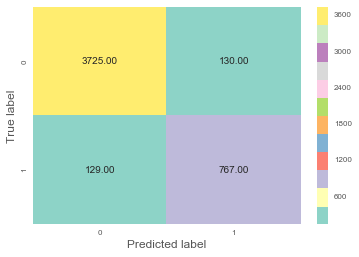

In [271]:
lr_cm = metrics.confusion_matrix(y_pred.predicted, y_pred.actual)
sns.heatmap(
    lr_cm,
    annot=True,
    cmap='Set3',
    fmt='.2f',
)

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Segmentation

In [272]:
#Apply TfidfVectorizer to review text
from sklearn.cluster import KMeans
from sklearn import metrics

In [273]:
# get the tf-idf table 

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 1), 
                             stop_words='english')
vectorizer.fit(df['RequiredQualifications'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=0.05, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [274]:
# Data Selection
cluster = df[['RequiredQualifications']]

In [275]:
cluster['RequiredQualifications'] = cluster['RequiredQualifications'].astype(str)

### Removal of Punctuations and Conversion to Lower-case

In [276]:
def remove_punctuations(text):
    text=re.sub(r'!"#$%&()*,-./:;<=>?@\[]^_`{|}~','', text)                # Remove punctuations
    text=text.lower()                                       # Convert text to lower
    return(text)

cluster['RequiredQualifications']=cluster['RequiredQualifications'].apply( lambda x: remove_punctuations(x))
cluster['RequiredQualifications'].head(5)

0    to perform this job successfully, an\nindividu...
1    - bachelor's degree; master's is preferred;\n-...
2    - degree in environmentally related field, or ...
3    - advanced degree in public health, social sci...
4    - university degree; economical background is ...
Name: RequiredQualifications, dtype: object

In [277]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.9,
                             ngram_range=(1, 4), 
                             stop_words='english')
vectorizer.fit(cluster['RequiredQualifications'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=0.1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [278]:
X_train = vectorizer.transform(cluster['RequiredQualifications'])
vocab = vectorizer.get_feature_names()

In [279]:
vocab[:20]

['ability',
 'ability work',
 'ability work pressure',
 'accounting',
 'advanced',
 'analytical',
 'armenian',
 'armenian english',
 'armenian russian',
 'armenian russian english',
 'armenian russian english languages',
 'armenian russian languages',
 'basic',
 'business',
 'communication',
 'communication skills',
 'computer',
 'computer skills',
 'degree',
 'design']

In [280]:
# get the tf-idf table
vectorizer = TfidfVectorizer(min_df=0.05,
                             max_df=0.95,
                             ngram_range=(1, 2),
                             stop_words='english')
vectorizer.fit(cluster['RequiredQualifications'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=0.05, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [281]:
X_train = vectorizer.transform(cluster['RequiredQualifications'])
vocab = vectorizer.get_feature_names()

In [282]:
vocab[:10]

['ability',
 'ability work',
 'accounting',
 'administration',
 'advanced',
 'advantage',
 'analysis',
 'analytical',
 'analytical skills',
 'applications']

In [295]:
# we create a kmeans model
model = KMeans(n_clusters=6, 
               init='k-means++', 
               max_iter=100, n_init=1,random_state=5)

In [296]:
# apply the model on this prepared data
res = model.fit(X_train)
res

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=6, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=5, tol=0.0001, verbose=0)

In [297]:
# Getting the vocalbulary as well as cluster centers
# Firstly, set of words from the tf-idf itself
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)

In [298]:
# Then, the cluster centers from the model fit that we stored on res
cluster_centers = np.array(res.cluster_centers_)

In [299]:
# Then, the cluster centers from the model fit that we stored on res
cluster_centers = np.array(res.cluster_centers_)

In [300]:
#x=np.array((0.1,10,0.05,1.5))
#print(x)
#print(x.argsort())
res.cluster_centers_[0].argsort()

array([ 82,  81,  72,  68, 162, 140,  96, 176, 205, 161, 204, 178,  70,
        93,   2,  26,  32,  74, 187,  16, 206, 160, 150, 105, 110, 132,
       115,  69, 197,  29, 136, 175, 183,  30,  60, 135,  89, 210,  76,
       188, 181,  98, 179,  39, 125, 159, 185, 172, 199, 120, 113, 171,
        99, 122, 170, 118,   8, 169, 114, 131, 189,  34,  28, 198,  94,
       190,  20, 163, 167, 134, 168, 156, 101, 166, 196,  18,  71,   9,
        46, 153,   6,  19,   1,  65,  86,  92,  91,  57,  80,  50,  17,
       130,  67, 157,  47,  58,  75, 123, 119,  59,  38, 164, 192, 107,
       124, 127, 104,  87, 215,  53, 211,  55,  13,  62, 103, 182, 193,
       139,   7,  25, 141,  63, 133, 201, 155,  79, 109,  33, 106, 121,
       138, 117, 174,  15,  73,  27, 212,  97, 184, 158,  78,  84,  51,
       186, 112, 144, 216, 147, 177,  35, 143,  42,  40, 173,   4,  54,
         5,  45, 208, 152,  12, 129, 191, 108, 149,  48,  37,  10,  95,
       200,  23, 128, 154,  85,  14, 142,  66,   3, 126,  36, 21

In [301]:
# sorting the cluster centers
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]

In [302]:
sorted_vals

[array([ 82,  81,  72,  68, 162, 140,  96, 176, 205, 161, 204, 178,  70,
         93,   2,  26,  32,  74, 187,  16, 206, 160, 150, 105, 110, 132,
        115,  69, 197,  29, 136, 175, 183,  30,  60, 135,  89, 210,  76,
        188, 181,  98, 179,  39, 125, 159, 185, 172, 199, 120, 113, 171,
         99, 122, 170, 118,   8, 169, 114, 131, 189,  34,  28, 198,  94,
        190,  20, 163, 167, 134, 168, 156, 101, 166, 196,  18,  71,   9,
         46, 153,   6,  19,   1,  65,  86,  92,  91,  57,  80,  50,  17,
        130,  67, 157,  47,  58,  75, 123, 119,  59,  38, 164, 192, 107,
        124, 127, 104,  87, 215,  53, 211,  55,  13,  62, 103, 182, 193,
        139,   7,  25, 141,  63, 133, 201, 155,  79, 109,  33, 106, 121,
        138, 117, 174,  15,  73,  27, 212,  97, 184, 158,  78,  84,  51,
        186, 112, 144, 216, 147, 177,  35, 143,  42,  40, 173,   4,  54,
          5,  45, 208, 152,  12, 129, 191, 108, 149,  48,  37,  10,  95,
        200,  23, 128, 154,  85,  14, 142,  66,   3

In [303]:
# get top 10 words from that cluster
words=set()
for i in range(len(res.cluster_centers_)):
    words = set(vocab[sorted_vals[i][-10:]])
    print(words)

{'years', 'skills', 'university degree', 'english', 'university', 'experience', 'work', 'knowledge', 'degree', 'management'}
{'skills', 'excellent', 'languages', 'education', 'russian', 'experience', 'higher education', 'work', 'knowledge', 'higher'}
{'learn', 'skills', 'flexible', 'oral written', 'written communication', 'skills armenian', 'russian language', 'language plus', 'mail', 'communication skills'}
{'skills', 'ability', 'design', 'development', 'good', 'software', 'sql', 'experience', 'web', 'knowledge'}
{'strong', 'skills', 'ability', 'skills ability', 'excellent', 'ability work', 'communication', 'experience', 'work', 'knowledge'}
{'skills', 'armenian', 'ability', 'financial', 'standards', 'experience', 'work', 'accounting', 'knowledge', 'finance'}


In [304]:
words=list(words)

In [305]:
# how many observations are in each cluster

cluster['cluster'] = model.labels_
cluster.groupby('cluster').count()

,RequiredQualifications
cluster,
0,4933
1,3059
2,572
3,4044
4,4833
5,1560


In [306]:
cluster

,RequiredQualifications,cluster
0,"to perform this job successfully, an\nindividu...",5
1,- bachelor's degree; master's is preferred;\n-...,4
2,"- degree in environmentally related field, or ...",0
3,"- advanced degree in public health, social sci...",0
4,- university degree; economical background is ...,3
...,...,...
18996,- at least 5 years of experience in interface/...,3
18997,"- university degree, ideally business related;...",4
18998,"- degree in business, marketing or a related f...",0
18999,- at least 1 year of experience in online sale...,0


## Topic Modelling

In [307]:
decomposition.LatentDirichletAllocation?

In [308]:
#train a LDA Model

from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=10,
                                      learning_method='online',
                                      max_iter=50)
X_topics = lda_model.fit_transform(X_train)
topic_word = lda_model.components_
vocab = vectorizer.get_feature_names()

In [309]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words +
                                                             1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['communication skills oral written skills armenian skills written communication russian language mail language plus learn flexible',
 'skills excellent ability work strong organizational analytical english russian ability work organizational skills',
 'experience skills ability management international knowledge work excellent degree written',
 'experience knowledge ability development skills problem degree computer solving problem solving computer science',
 'skills responsibility sense sense responsibility high excellent knowledge work ability high sense',
 'knowledge russian languages higher education knowledge armenian ms armenian higher education office',
 'education higher education higher work ability ability work deadlines meet pressure work pressure',
 'knowledge experience good design programming development web sql language plus',
 'accounting banking finance financial knowledge bank legislation economics standards experience',
 'skills computer literacy field knowledge exp

In [310]:
frequency_words_wo_stop = {}
for data in cluster['RequiredQualifications']:
    tokens = nltk.wordpunct_tokenize(data.lower())
    for token in tokens:
        if token.lower() not in stop:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1

In [311]:
frequency_words_wo_stop

{'perform': 280,
 'job': 430,
 'successfully': 124,
 ',': 73701,
 'individual': 243,
 'must': 501,
 'able': 354,
 'essential': 289,
 'duty': 36,
 'satisfactorily': 8,
 '.': 25782,
 'requirements': 791,
 'listed': 30,
 'representative': 66,
 'knowledge': 37399,
 'skill': 167,
 '/': 12111,
 'ability': 23313,
 'required': 808,
 ':': 5099,
 '-': 174694,
 'generally': 60,
 'accepted': 137,
 'accounting': 4094,
 'principles': 1329,
 ';': 133324,
 'local': 903,
 'standards': 1368,
 'legislation': 1713,
 'state': 235,
 'reporting': 975,
 'pertaining': 7,
 'practices': 697,
 'financial': 2531,
 'management': 6938,
 'budgeting': 263,
 'systems': 2335,
 'design': 3241,
 'analysis': 1294,
 'contract': 87,
 'records': 70,
 'risk': 296,
 'supervision': 592,
 'information': 1529,
 'apply': 392,
 'sound': 368,
 'fiscal': 26,
 'administrative': 472,
 'company': 714,
 "'": 2840,
 'activities': 633,
 'plan': 306,
 'organize': 291,
 'supervise': 44,
 'work': 20930,
 'subordinate': 3,
 'employees': 105,
 '

In [329]:
from nltk import FreqDist
fdist1 = FreqDist(frequency_words_wo_stop)
fdist1.items()

dict_items([('perform', 280), ('job', 430), ('successfully', 124), (',', 73701), ('individual', 243), ('must', 501), ('able', 354), ('essential', 289), ('duty', 36), ('satisfactorily', 8), ('.', 25782), ('requirements', 791), ('listed', 30), ('representative', 66), ('knowledge', 37399), ('skill', 167), ('/', 12111), ('ability', 23313), ('required', 808), (':', 5099), ('-', 174694), ('generally', 60), ('accepted', 137), ('accounting', 4094), ('principles', 1329), (';', 133324), ('local', 903), ('standards', 1368), ('legislation', 1713), ('state', 235), ('reporting', 975), ('pertaining', 7), ('practices', 697), ('financial', 2531), ('management', 6938), ('budgeting', 263), ('systems', 2335), ('design', 3241), ('analysis', 1294), ('contract', 87), ('records', 70), ('risk', 296), ('supervision', 592), ('information', 1529), ('apply', 392), ('sound', 368), ('fiscal', 26), ('administrative', 472), ('company', 714), ("'", 2840), ('activities', 633), ('plan', 306), ('organize', 291), ('supervi

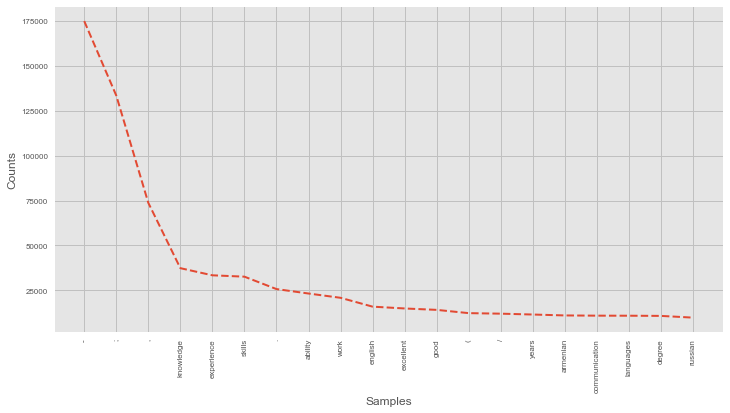

In [330]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# plot the top 20 tokens
fdist1.plot(20)

In [338]:
vocabulary1 = fdist1.keys() # list of all the distinct types in the text
vocabulary1 # look at first 3

dict_keys(['perform', 'job', 'successfully', ',', 'individual', 'must', 'able', 'essential', 'duty', 'satisfactorily', '.', 'requirements', 'listed', 'representative', 'knowledge', 'skill', '/', 'ability', 'required', ':', '-', 'generally', 'accepted', 'accounting', 'principles', ';', 'local', 'standards', 'legislation', 'state', 'reporting', 'pertaining', 'practices', 'financial', 'management', 'budgeting', 'systems', 'design', 'analysis', 'contract', 'records', 'risk', 'supervision', 'information', 'apply', 'sound', 'fiscal', 'administrative', 'company', "'", 'activities', 'plan', 'organize', 'supervise', 'work', 'subordinate', 'employees', 'including', 'training', 'assigning', 'evaluating', 'providing', 'performance', 'feedback', 'critically', 'analyze', 'policies', 'procedures', 'recommend', 'implement', 'changes', 'needed', 'gather', 'synthesize', 'variety', 'sources', 'present', 'audiences', 'differing', 'expertise', 'prepare', 'detailed', 'comprehensive', 'reports', 'explanatory

## Important Notes

We got out best score using Random Forest Classifier. The predictions score with the test data in the train dataset comes to be around 96%.

If we use test data, we got a prediction score of around 92%.

I have made 6 clusters for unsupervised learning.

If there are any challenges/remarks in the case study analysis, kindly let me know so I can improve myself on my mistakes just like these Machine Learning Models. :D 

### Thank You!